### Count regression

This notebook demonstrates the use of TFP for regression on count data. The dataset is the number of fish caught in a state park. 

* Linear Regression
* Poisson Regression
* Zero Infated Poisson Regression

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


##### Creating some count data for figure 5.rain

This is just to demonstrate how to use TF distributions for a Poisson distribution, with given parameters. Below we learn the paramters. 

2.0
1.4142135


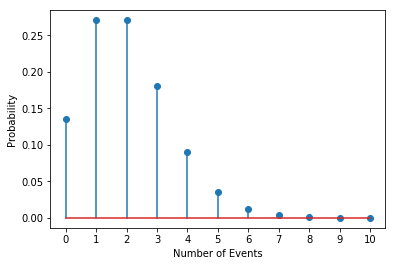

In [3]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E
plt.xticks(vals)
plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.savefig('ch05_rain.pdf')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

## Loading some real count data

We use some traditional count data from: https://stats.idre.ucla.edu/r/dae/zip/. The number fish caught during a state park visit.

In [4]:
# Alternative dataset version
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/nb_data.csv') 
# X = dat[...,0:3]
# y = dat[...,4]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [5]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
#y = np.sqrt(dat[...,7])
y = dat[...,7]

In [6]:
# Uncomment the next line, to enhance the ZIP model (see below why you would like to do it)
# n = len(y)
# idx = np.random.permutation(n)[0:int(n*0.3)] 
# y[idx] = 0

In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=seed,shuffle=True)
d = X_tr.shape[1]
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape, y_te, y_tr

((200, 4),
 (200,),
 (50, 4),
 (50,),
 (250, 8),
 array([ 0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  2.,  1.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  1.,  3.,  6.,
        65.,  0.,  0.,  0., 16.,  0.,  0.,  6.,  0.,  9.,  0.]),
 array([  6.,   1.,   6.,   1.,   3.,   1.,   0.,  15.,   0.,   2.,   0.,
          2.,   0.,   2.,   3.,   0.,   0.,   1.,   5.,   0.,   0.,   0.,
          2.,   0.,   0.,   5.,   0.,   4.,   2.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,
          0.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,  21.,   0.,
         32.,   2.,   0.,   0.,   9.,  13.,   1.,   0.,   1.,  31.,   0.,
          0.,   0.,   0.,   3.,   3.,   0.,   0.,   1.,   1.,   0.,   1.,
          2.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,  11.,   0.,  21.,   0.,   2.,   5.,   3.,   4.,   0.,   7.,
 

149.0

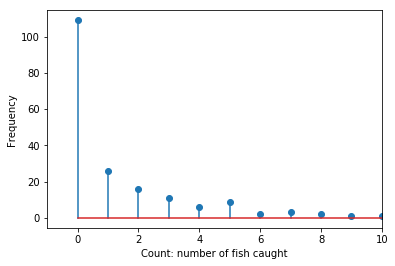

In [9]:
vals, counts = np.unique(y_tr, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,10)
plt.savefig('ch05_school.pdf')
np.max(y_tr)

## 1 Doing linear regression

### 1.1 Assuming constant variance and using MSE 

In this section we do a linear regression, for the count data.

#### 1.1.1 With sklearn 

Linear regression can also be done with mehods specialized for that case. Let's compare the results:

In [10]:
# The linear regression using non deep learning methods
# These methods have no problem with convergence 
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()
res = model_skl.fit(X_tr, y_tr)

Estimating the likelihood in LR (estimating $\sigma$)

In linear regression, we assuming that the $\sigma$ is constant. To calculate the NLL, we need to estimate this quantity from the training data. But the prediction is of course done on the testdata. Note that we calculate the mean NLL.

In [11]:
import pandas as pd
# Calculation of the NLL (using deep learnin)
y_hat_tr = model_skl.predict(X_tr) #Trainingset!
n = len(y_hat_tr)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_hat_tr.flatten() - y_tr)
print('Estimated variance ', sigma_hat_2)

y_hat = model_skl.predict(X_te) #Prediction on the testset
#Alternatively: y_hat = np.matmul(X_te,res.coef_) + res.intercept_
MSE_skl = np.sqrt(np.mean((y_te - y_hat)**2))
MAE_skl = np.mean(np.abs(y_hat - y_te)) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat - y_te)**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_tr - y_tr)**2)/sigma_hat_2)

df = pd.DataFrame(
          {'RMSE' : MSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df

Estimated variance  117.86174791690665
NLL on training: 3.8011821252657967


,MAE,NLL (mean),RMSE
Linear Regression (sklearn),4.70509,3.616586,8.588126


#### 1.1.2 With Keras

We use Keras to directly optimize the MSE. 

In [12]:
model_lr = tf.keras.Sequential() 
model_lr.add(tf.keras.layers.Dense(1,input_dim=d, activation='linear')) 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))

In [13]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=5000, verbose=False, batch_size=len(y_tr));
#hist_lr = model_lr.fit(x=X_tr, y=np.sqrt(y_tr), validation_data=(X_te, y_te), epochs=600, verbose=False);

76.84066018066406

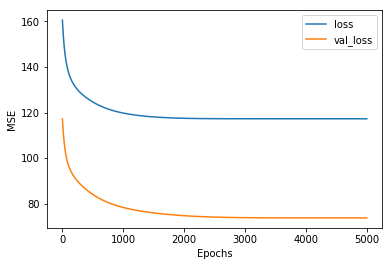

In [14]:
plt.plot(hist_lr.history['loss']) #Note this is the MSE and not the RMSE
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['val_loss'])

Comparing Keras and sklearn

In [15]:
print('weights using deep learning:          ',model_lr.get_weights()[0][:,0])
print('weights from sklearn:                 ',res.coef_)
print('Intercept (bias) using deep learning: ',model_lr.get_weights()[1][0])
print('Intercept (bias) using sklearn:       ',res.intercept_)

weights using deep learning:           [ 2.4821873  2.9542987  4.6495247 -5.4715924]
weights from sklearn:                  [ 2.4822138   2.95430727  4.64953914 -5.47160051]
Intercept (bias) using deep learning:  -8.4921665
Intercept (bias) using sklearn:        -8.492228208419725


#### Evaluation of the Performance 

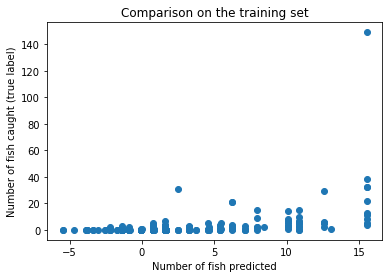

In [16]:
plt.scatter(y_hat_tr, y_tr)
plt.title('Comparison on the training set')
plt.xlabel('Number of fish predicted')
plt.ylabel('Number of fish caught (true label)')
plt.show()

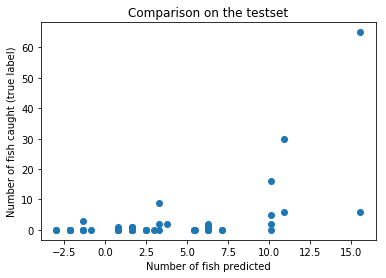

In [17]:
y_hat_te = model_lr.predict(X_te)
plt.scatter(y_hat_te, y_te)
plt.title('Comparison on the testset')
plt.xlabel('Number of fish predicted')
plt.ylabel('Number of fish caught (true label)')
plt.show()

Note that the linear model predicts also negative values, which is obviously wrong. 

In [18]:
y_hat_tr = model_lr.predict(X_tr) #Trainingset
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_hat_tr.flatten() - y_tr)
print('Estimated variance ', sigma_hat_2)

y_hat_te = model_lr.predict(X_te).flatten()
NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2

mse_lr=np.sqrt(np.mean((y_hat_te - y_te)**2))
mae_lr=np.mean(np.abs(y_hat_te - y_te)) 



df1 = pd.DataFrame(
         { 'RMSE' : mse_lr, 'MAE' : mae_lr, 'NLL (mean)' : NLL_lr}, index=['Linear Regression (MSE Keras)']
)

df = df.append(df1)
df

Estimated variance  117.86174861906474


,MAE,NLL (mean),RMSE
Linear Regression (sklearn),4.705090,3.616586,8.588126
Linear Regression (MSE Keras),4.705087,3.616586,8.588128


#### 1.1.3 With TFP 

In the standard linear regression $\sigma$ does not depend x, it is assumed to be the same at each position. To mimik this in the network, we here introduce a variable not connected to the data.

In [19]:
# sig = tf.Variable(1.1153, dtype='float32') #The Variable sigma, which we also learn

# def gauss(out): 
#     return tfd.Normal(loc=out, scale=sig)

# def negloglik(y_true, y_hat): 
#   return -tf.reduce_mean(y_hat.log_prob(y_true))

# inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
# mu = tf.keras.layers.Dense(1)(inputs)
# #out = tf.concat([mu, sig],axis=-1)
# p_y = tfp.layers.DistributionLambda(gauss)(mu) 
# model_lr_tfp = Model(inputs=inputs, outputs=p_y) 


# model_lr_tfp.compile(tf.optimizers.Adam(learning_rate=0.01),loss=negloglik) 

#### [Optional] Fitting using eager mode

In [20]:
# optimizer=tf.optimizers.RMSprop()
# loss_values = np.zeros((500))
# for e in range(500):
#     with tf.GradientTape() as tape:
#         y_hat = model_lr(X_tr)
#         loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
#         loss_values[e] = loss_value
#         weights =  model_lr_tfp.trainable_weights
#         weights.append(sig)
#         grads = tape.gradient(loss_value, weights)              
#         #weights =  model_lr.trainable_weights
#         optimizer.apply_gradients(zip(grads,weights))
#         if e % 100 == 0:
#             print(loss_value, " ", sig)

In [21]:
# Need quite some time to converge
#hist_lr_tfp = model_lr_tfp.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=10000, verbose=False);

In [22]:
# print('weights using deep learning:          ',model_lr_tfp.get_weights()[0][:,0])
# print('weights from sklearn:                 ',res.coef_)
# print('Intercept (bias) using deep learning: ',model_lr_tfp.get_weights()[1][0])
# print('Intercept (bias) using sklearn:       ',res.intercept_)

In [23]:
# plt.plot(hist_lr_tfp.history['loss']) #Note this is the MSE and not the RMSE
# plt.plot(hist_lr_tfp.history['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# np.mean(hist_lr_tfp.history['val_loss'])

In [24]:
#sig

In [25]:
# sigma_hat_2 = sig.numpy()
# print('Estimated variance ', sigma_hat_2)

# model = Model(inputs=inputs, outputs=p_y.mean()) 
# y_hat_te = model.predict(X_te).flatten()

# mse_lr=np.sqrt(np.mean((y_hat_te - y_te)**2))
# mae_lr=np.mean(np.abs(y_hat_te - y_te)) 


# NLL_lr = model_lr_tfp.evaluate(X_te, y_te) #returns the NLL 
# df1 = pd.DataFrame(
#          { 'RMSE' : mse_lr, 'MAE' : mae_lr, 'NLL (mean)' : NLL_lr}, index=['Linear Regression (TFP)']
# )

# df = df.append(df1)
# df

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [26]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(inputs)
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.01), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.


model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False);

(2.5, 4.5)

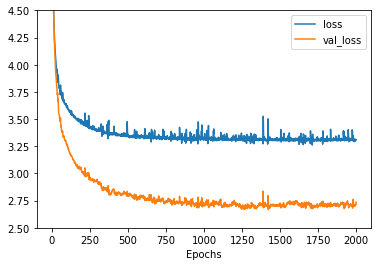

In [28]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
np.mean(hist_p.history['loss'])
plt.ylim(2.5,4.5)

In [29]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_te = model.predict(X_te).flatten()


mse=np.sqrt(np.mean((y_hat_te - y_te)**2))
mae=np.mean(np.abs(y_hat_te - y_te)) 

NLL = model_p.evaluate(X_te, y_te) #returns the NLL 

df1 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['Poisson Regression (TFP)']
)
df1
df = df.append(df1)
df

50/50 [==============================] - 0s 62us/sample - loss: 2.7358


,MAE,NLL (mean),RMSE
Linear Regression (sklearn),4.705090,3.616586,8.588126
Linear Regression (MSE Keras),4.705087,3.616586,8.588128
Poisson Regression (TFP),3.045626,2.735845,7.363067


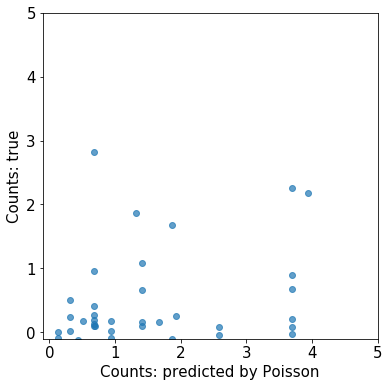

In [39]:
plt.figure(figsize=(6,6))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen
plt.xlim(-0.1,5)
plt.ylim(-0.1,5)
y_hat_te = model(X_te)
plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by Poisson')
plt.ylabel('Counts: true')
plt.savefig('ch05_pois.pdf')

This time there a no values less then zero.

## 3 Using zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [31]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    #print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [32]:
## testinging the distribution, we evalute some data 
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
print('Input Tensor : ',t)
print('Output Mean  : ',zero_inf(t).mean().numpy())

W0718 16:09:24.215142 140568438875904 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


Input Tensor :  [[ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 0.999 10.   ]]
Output Mean  :  [1.9872233 1.9872233 1.9872233 1.9872233 2.7154417]


### Definition of the model

In [33]:
## Definition of the model
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
## Definition of the custom parametrized distribution
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
out = Dense(2,  #A
            kernel_regularizer=l2(0.01), #B
            bias_regularizer=l2(0.01))(inputs)#B
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
#B Using a regularisation prevents the network from learning too large weights. Without regularisation, you run into numerical problems.
model_zi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_1 (Distr ((None,), (None,))        0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### Training of the model (by hand) [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, which we got rid off using regularisation. See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [34]:
optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
loss_values = np.zeros((1000))
for e in range(5):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_tr)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))

### Training using keras' build in training

In [35]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik2)
hist_zi = model_zi.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False)#, callbacks=[tb]);

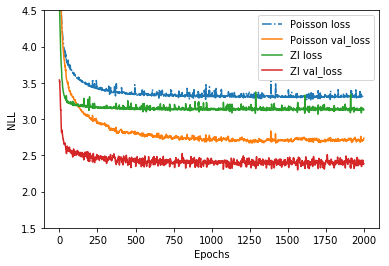

In [36]:
plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_p.history['val_loss'])
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.ylim(1.5,4.5)
plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
#plt.legend(['Poisson','Zero-Inflated'])
#plt.legend(['loss','val'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.savefig('ch05_flik.pdf')

In [37]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_te = model.predict(X_te).flatten()


mse=np.sqrt(np.mean((y_hat_te - y_te)**2))
mae=np.mean(np.abs(y_hat_te - y_te)) 

NLL = model_zi.evaluate(X_te, y_te) #returns the NLL 


df1 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['ZIP (TFP)']
)
df1
df = df.append(df1)
df

50/50 [==============================] - 0s 43us/sample - loss: 2.3844


,MAE,NLL (mean),RMSE
Linear Regression (sklearn),4.705090,3.616586,8.588126
Linear Regression (MSE Keras),4.705087,3.616586,8.588128
Poisson Regression (TFP),3.045626,2.735845,7.363067
ZIP (TFP),3.154015,2.384404,7.610579


Training Set 2.7155964 35
Validation Set 3.2108147 24


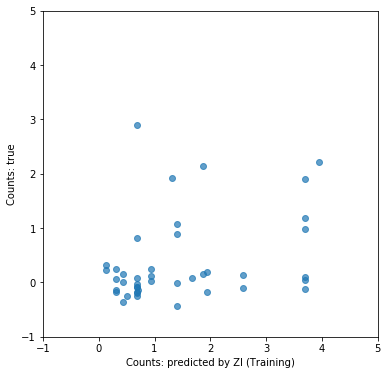

In [38]:
plt.figure(figsize=(6,6))
plt.xlim(-1,5)
plt.ylim(-1,5)
y_hat_tr = model_zi(X_tr)

plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by ZI (Training)')
plt.ylabel('Counts: true')

plt.savefig('ch05_zi.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

Note that the ZIP model is not so much better then the Poisson model. Let's see what happens if you make more fisherman unlucky and remove randomly remove some catched. You can uncomment the lines in cell 6.